[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MaralAminpour/ML-BME-Course-UofA-Fall-2023/blob/main/Week-7-Ensemble-learning/7.Ensemble_Learning.ipynb)

# Ensemble Learning: Bagging, Boosting, Random Forests and Stacking

Now that we have learnt about weak learners, and know how to generate decision trees from scratch we will move on to discussing ensemble learning with specific focus on homogenous ensembles.

Let's start by importing the modules we will need.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Motivation

The goal of ensemble learning is to improve the accuracy and/or generalisability of machine learning (ML) approaches by combining predictions from several models.

There are several approaches to ensemble learning, which vary in whether they combine predictions made from the same class of base learners (otherwise known as __homogenous ensembles__) or whether they merge predictions from multiple different types of base learner (e.g. __heterogenous ensembles__). Ensemble methods also vary in how they combine predictions; specifically choosing either to generate base learners __sequentially__ or in __parallel__.

The choice of sequential or parallel learning impacts differently on how the ensemble reduces model error. Remember, from the first lecture, the error emerging from any model can be broken down into three components:

$$𝐸𝑟𝑟(𝑥)=𝐵𝑖𝑎𝑠^2+𝑉𝑎𝑟𝑖𝑎𝑛𝑐𝑒+𝐼𝑟𝑟𝑒𝑑𝑢𝑐𝑖𝑏𝑙𝑒𝐸𝑟𝑟𝑜𝑟$$

<img src="https://raw.githubusercontent.com/MaralAminpour/ML-BME-Course-UofA-Fall-2023/main/Week-7-Ensemble-learning/imgs/biasvariance2.png" style="max-width:100%; width: 60%; max-width: none">


Learning sequentially enables methods to exploit the dependence between base learners. Each new learner upweights mislabeled examples; thus learning a complementary set of predictors that reduce the bias and boost the accuracy of the model.

On the other hand parallel ensembles combine predictions learnt from multiple models run independently, and thus average away the impact of isolated errors, reducing the variance of the prediction.

In this course we will discuss the following specific examples of homogenous ensembles:

- Voting
- Bagging (Bootstrapp Aggregation)
- Boosting
- Random Forests

Of these, Boosting represents sequential ensemble learning and Bagging, voting and forests reflect parallel learning (note Random Forests are a generalisation of Bagging).

In the next section, we will present a simple intuitive example of why ensemble learning works, through simple vote based aggregation.

## 1.1. Voting: A toy example*

*Taken from https://mlwave.com/kaggle-ensembling-guide/; this pages supplies number of excellent examples of ensemble learning (particular heterogenous forms) based on how they have performed on Kaggle Challenges

Suppose we have a test set of 10 samples. The ground truth is all positive (“1”): ```y={1,1,1,1,1,1,1,1,1,1}```

Furthermore, suppose we have 3 binary classifiers: A,B,C, each with 70% accuracy e.g.

- $\hat{y_A}={1,1,0,1,1,1,1,1,0,0} $
- $\hat{y_B}={0,1,1,1,1,0,1,1,0,1} $
- $\hat{y_C}={1,1,1,0,0,1,1,0,1,1} $

If we were to combine these through majority voting (assigning a final class for each prediction from the most common class labels of each classifier) we then obtain:

- $\hat{y_{MV}}={1,1,1,1,1,1,1,1,0,1} $

This has 90% accuracy since, in all but one case, at least two of the classifier gave the correct prediction.

Using probability theory we can see that for any combination of predictions for which each our ($𝑦_𝑖$) are correct 70% of the time, we can increase our accuracy to 78% (on average). This can be seen through the combination of two probability rules:
1. For independent events the joint probability is the product of the marginals $P(\hat{y_A},\hat{y_B},\hat{y_C})=P(\hat{y_A})P(\hat{y_B})P(\hat{y_C)}$,
2. For mutually exclusive events (events which cannot both occur at the same time) the probability of either event $y_A$ or event $y_B$ occurring is: $P(y_A \cup y_B)=P(y_A)+P(y_B)$

Thus for a majority vote with 3 members we can expect 4 outcomes:

1. All three are correct: <br>
     0.7 \* 0.7 \* 0.7 <br>
   = 0.343
   
2. Two are correct (here we have 3 mutually exclusive events each with _joint_ probabiities - $P(\hat{y_A}=1,\hat{y_B}=1,\hat{y_C}=1)$ or $P(\hat{y_A}=1,\hat{y_B}=0,\hat{y_C}=1)$ or $P(\hat{y_A}=0,\hat{y_B}=1,\hat{y_C}=1)$: <br>
     0.7 \* 0.7 \* 0.3  + 0.7 \* 0.3 \* 0.7 + 0.3 \* 0.7 \* 0.7  <br>
   = 0.441
   
3. Two are wrong (here we have 3 mutually exclusive possibilities): <br>
     0.7 \* 0.3 \* 0.3  + 0.3 \* 0.7 \* 0.3 + 0.3 \* 0.3 \* 0.7  <br>
   = 0.189
   
3. All are wrong: <br>
     0.3 \* 0.3 \* 0.3   <br>
   = 0.027

We can see the taking a majority vote of the ensemble will result in a correct answer when at least 2 of the predictions are correct. Thus majority voting will correct the result ~ 44% of the time, will already be correct  38% of the time (when all 3 are correct) and thus (again through use of the OR rule) the ensemble will thus be correct an average of 0.441+0.343 = 0.784 % of the time.

Further if we were to repeat this experiment with more ensembles (**hint** try this) we would see that the prediction result increases. For example a voting ensemble of 5 classifiers with 70% accuracy would be correct ~83% of the time.

However, this is only true, if we select only uncorrelated ensembles. If we instead rain highly correlated predictive models then this would have limited or no impact:

- $\hat{y_A}={1,1,1,0,1,1,1,1,0,0} $ (70% accurate)
- $\hat{y_B}={1,1,1,0,1,1,1,1,0,0} $ (70% accurate)
- $\hat{y_C}={1,1,1,0,1,1,1,1,0,0} $ (70% accurate)

A majority result generates $\hat{y_{mv}}={1,1,1,0,1,1,1,1,0,0}$ which is still 70% accurate.

# 2. Homogenous Ensembles

## 2.1 Bagging

Bagging is a method for generating homogenous ensembles in parallel. In simple terms, it repeatedly trains on slightly different training sets and then aggregates the results by, for example, majority voting or averaging. The reason why this works is that through averaging, bagging reduces the variance of the final prediction model, where it can be shown that, For $T$ independent samples (here, predictions from trained models):

$$ var(\bar{y}) = \frac{var(y)}{T} $$

Where, $\bar{y}$ represents the mean of some quantity  $y$.

Thus averaging appreciably reduces the variance of the model. But how can we get $n$ independent samples from our data if we have only collected one dataset?

### 2.1.1 Bootstrapping

We can do this using ***Bootstrapping***. This refers to generating new datasets by repeatedly sampling from the available data with replacement.  Conventionally, the size of the bootstrapped sample is equal to that of the original sample. We will now look at generating our own boostrap function to sample rows from our data matrices by taking advantage of the random sampling functions supplied with numpy (https://docs.scipy.org/doc/numpy-1.14.0/reference/routines.random.html).

### Exercise 1: Generating bootstrapped samples

Complete the function ``` bootstrap_sample ``` to estimate a bootstrap sample from a given dataset of size (n_samples,n_features) using the numpy function  ```np.random.choice(a, size=None, replace=True, p=None)```.  In this function, if argument ```a``` is a 1D array, then  ```np.random.choice(a)``` will sample directly from it. However, here we wish to use it to generate random samples of row indices, corresponding to the rows of our data matrix ```dataset```

**To do**
Use ```np.random.choice``` in the function below to sample with replacement from our data matrix ```dataset```.
1. Return an array of ```indices``` to sample rows from ```dataset``` by creating a sample from ```np.random.choice```
    - **importantly bootstrapping expects sampling with replacement** and ```samples``` should have same number of rows as the original ```dataset```
2. Use this to create a new data matrix ```samples``` which slices rows from the matrix ```dataset``` corresponding to each element of ```indices```

[numpy.random_choice documentation](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html)

**If you get stuck there are more hints that you can lock by viewing the hidden cell below**

In [ ]:
# @title
#Note that if the first argument of ```np.random.choice(a, size=None, replace=True, p=None)``` (```a```) is
#    an integer (corresponding to the number of rows of a ```dataset```) then the function will return a random
#sample of indices in the range [0,a) with which to slice ```dataset``` with

#By way of example, let us assume we supply ```a=5```.
# Then np.random.choice(5, size=None, replace=True, p=None) would return a sample from ```[0,1,2,3,4].```
# Thus, when resampling with replacement (```replace=True```) an array of ```size=6```
#we might imagine returning an array such as ```[4, 0, 1, 4, 2, 1]```

In [ ]:
def bootstrap_sample(dataset,random_state=42):
    ''' Create a random subsample from the dataset with replacement
        input:
            dataset: (n_samples,n_features) data array
            random_state: fixes random seed
        output:
            samples: array of data bootstrapped from dataset
    '''
    n_sample = dataset.shape[0]
    indices = None

    samples = dataset[indices]

    return np.asarray(samples)

2. Now test this function on sampling from the below dataset

In [ ]:
dataset = np.asarray([[2.771244718,1.784783929,0],
           [1.728571309,1.169761413,0],
           [3.678319846,2.81281357,0],
           [3.961043357,2.61995032,0],
           [2.999208922,2.209014212,0],
           [7.497545867,3.162953546,1],
           [9.00220326,3.339047188,1],
           [7.444542326,0.476683375,1],
           [10.12493903,3.234550982,1],
           [6.642287351,3.319983761,1]])

test_sample=bootstrap_sample(dataset)
print('The original data set \n {}'.format(dataset))
print('Taking one bootstrapped sample returns \n {}'.format(test_sample))

The original data set 
 [[ 2.77124472  1.78478393  0.        ]
 [ 1.72857131  1.16976141  0.        ]
 [ 3.67831985  2.81281357  0.        ]
 [ 3.96104336  2.61995032  0.        ]
 [ 2.99920892  2.20901421  0.        ]
 [ 7.49754587  3.16295355  1.        ]
 [ 9.00220326  3.33904719  1.        ]
 [ 7.44454233  0.47668338  1.        ]
 [10.12493903  3.23455098  1.        ]
 [ 6.64228735  3.31998376  1.        ]]
Taking one bootstrapped sample returns 
 [[ 3.67831985  2.81281357  0.        ]
 [10.12493903  3.23455098  1.        ]
 [ 6.64228735  3.31998376  1.        ]
 [ 6.64228735  3.31998376  1.        ]
 [ 6.64228735  3.31998376  1.        ]
 [ 9.00220326  3.33904719  1.        ]
 [ 6.64228735  3.31998376  1.        ]
 [ 3.96104336  2.61995032  0.        ]
 [ 7.49754587  3.16295355  1.        ]
 [ 2.77124472  1.78478393  0.        ]]


### 2.1.2 Why Bootstrapping works...

For large enough samples it can be shown that Bootstrap sampling will closely approximate any sampling distribution estimated from the full population.

Take this example of estimating the mean from some population (simulated from random data as the variable ```DATA_population```). We can sample from this population many times using ```np.random.choice(..)``` to simulate the sample distribution of the population mean ```population_means```.

Now, assume this full sample of the population is unavailable to us (as in most real world experiments). In that case we would generally try to approximate the population by taking a single sample; let's call this the ```DATA_sample```. In bootstrapping what we do is repeatedly sample from ```DATA_sample``` _with replacement_ to get $m$ different bootstrapped samples  of the mean (```sample_means```). What we can see from the below experiment, is that if our sample sizes are large enough, then the bootstrapped sample distribution comes very close to the population sample distribution. Observe how the histrograms representing each distribution overlap much more considerably for larger sample sizes

<a id='bootsrapping'></a>



The mean of the population is 9.51004 


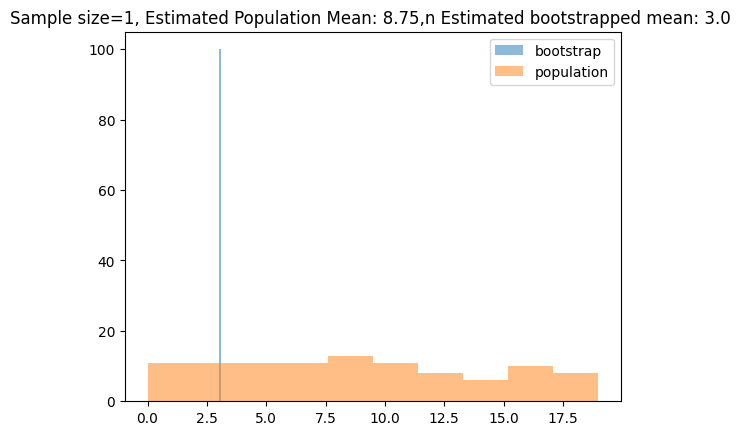

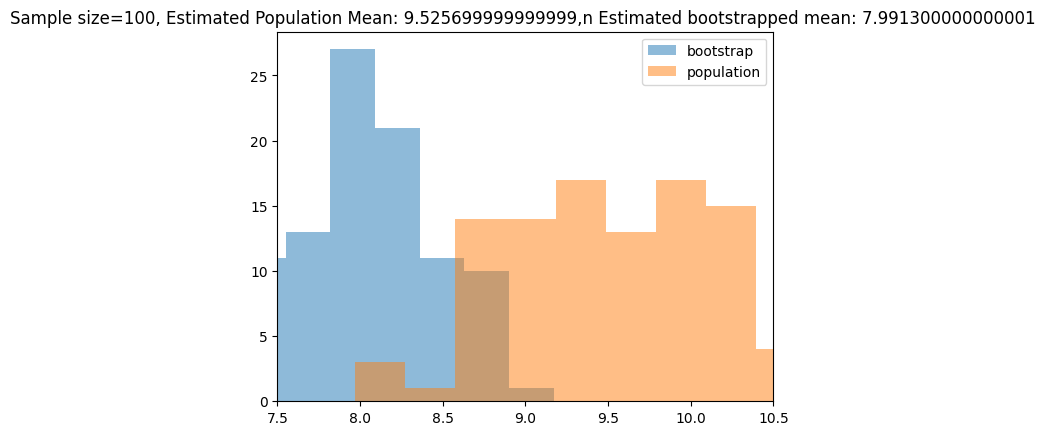

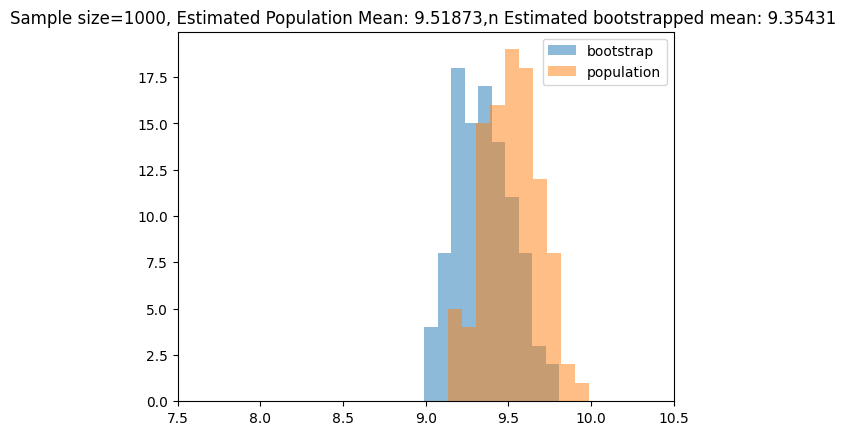

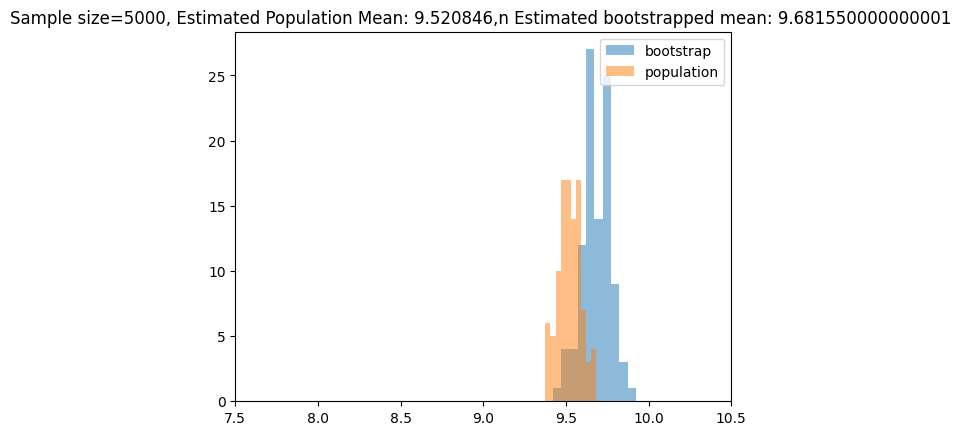

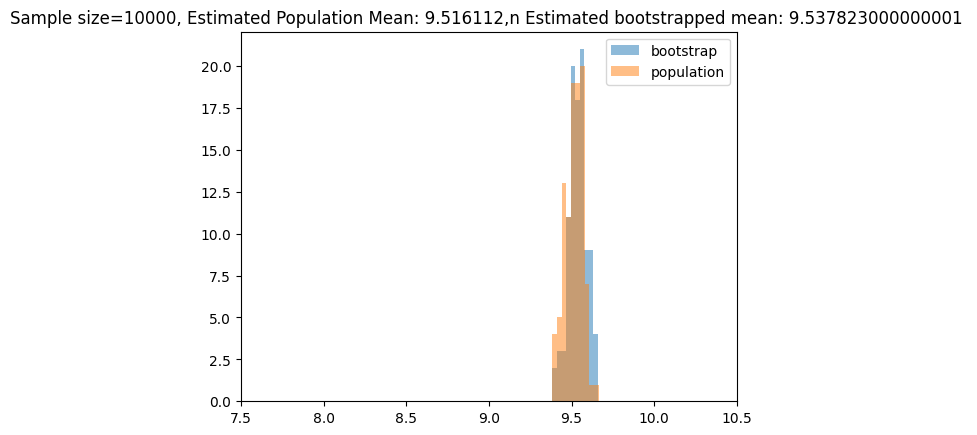

In [ ]:
# ######### TRIALING BOOTSTRAP SAMPLING FROM A  VECTOR #################

np.random.seed(1)

# simulate the data from a population
DATA_population=np.random.randint(0,20,100000)
print('The mean of the population is {} '.format(np.mean(DATA_population)))

n_samples=100 # fix number of samples estimated to 100

# comparing bootstrap and population sample distributions for different
#initial sample_sizes
for sample_size in [1, 100, 1000,5000,10000]:
    # sample one example of size sample_size from our data population
    DATA_sample=np.random.choice(DATA_population, sample_size)
    sample_means = []; population_means = []
    f=plt.figure()
    for i in range(n_samples):
        # repeatedly sample with replacement from our data population
        population_sample = np.random.choice(DATA_population, sample_size)
        # create a bootstrapped of our original sample
        sample = bootstrap_sample(DATA_sample)
        #compare mean of bootsrapped sample
        sample_means.append(np.mean(sample))
        # against mean of the sampling distribution
        population_means.append(np.mean(population_sample))
    # plot distributions on overlapping histograms
    plt.hist(sample_means, 10, alpha=0.5, label='bootstrap')
    plt.hist(population_means, 10, alpha=0.5, label='population')
    if sample_size > 1:
        # plot all but first with same x-range to allow fair comparison
        plt.xlim((7.5,10.5))
    plt.legend(loc='upper right')
    plt.title('Sample size={}, Estimated Population Mean: {},n Estimated bootstrapped mean: {} '
              .format(sample_size, np.mean(population_means),np.mean(sample_means)))



### 2.1.3  Bagging: Aggregating Results

Returning to the concept of bagging. Here, Bootstrapping is used to generate m different training sets. Bagging simply optimises a separate weak learner for each training set, runs test data through each weak learner and then aggregates the result, or step by step:

1. Take original dataset $X$ with $N$ training examples
2. Create _M_ copies  $\{\tilde{X}_𝑚 \}_{𝑚=1} ^{𝑀}$  by sampling _with replacement_
    -  Each $\tilde{X}_𝑚$ is different since some examples will get repeated and some will not be sampled at all
3. Train a separate weak learner on each Bootstrap sample
4. Test data on each weak learner
5. Aggregate results

### How to Aggregate

The method of aggregation changes depending on whether you are running a classification or regression task. For classification, the final prediction is typically a majority votes across all predictions, for each weak learner (in this case we assume these are _T_ decision trees):

$$ \bar{f}(\mathbf{X})=mode \{f_1(\mathbf{X}), f_2(\mathbf{X}).... f_T(\mathbf{X}))\} $$

Whereas for regression the final prediction is an average over all tree predictions:

$$ \bar{f}(\mathbf{x})=\sum_{i=1}^T f_i(\mathbf{x}) $$


### 2.1.4 Building a Bagging Classifer

### Exercise 2:

Now we have everything we need to construct a bagging classifer. As the weak learner we are going to use our decision tree from the last lecture. The following code downloads and imports a Pyhton script that implements a Decision Tree Predictor using gini coefficient as cost.

In [ ]:
# This code will download the required data files from GitHub
import requests

def download_data(source, dest):
    base_url = 'https://raw.githubusercontent.com/'
    owner = 'MaralAminpour'
    repo = 'ML-BME-Course-UofA-Fall-2023'
    branch = 'main'
    url = '{}/{}/{}/{}/{}'.format(base_url, owner, repo, branch, source)
    r = requests.get(url)
    f = open(dest, 'wb')
    f.write(r.content)
    f.close()

download_data('Week-7-Ensemble-learning/DecisionTree.py', 'DecisionTree.py')

import DecisionTree as DT

Now, all we need is two more functions:

1. To create an ensemble of trees, by generating $M$ bootstrapped training data examples and using these to create $M$ different decision trees.
2. To make a prediction by passing our test data down each tree in the ensemble, saving the predictions and then aggregrating them.

Starting with

1. Complete ```create_bagged_ensemble``` by creating a loop that
    - creates a bootstrap sample of the data (using ```bootstrap_sample``` from above)
    - builds a new decision tree from this training sample (***hint*** by calling function ```build_tree ``` from our ```DecisionTree``` module)
    - adds this tree to the list ```bagged_ensemble```


In [ ]:
def create_bagged_ensemble(data, max_depth, min_size, n_trees, random_state=42):

    ''' Create a bagged ensemble of decision trees
    input:
        data: (n_samples,n_features) data array
        max_depth: max depth of trees
        min_size: minimum number of samples allowed in tree leaf nodes
        n_trees: total number of trees in the ensemble
        random_state: fixes random seed
    output:
        bagged_ensemble: list of decision trees that make up the bagged ensemble
    '''
    bagged_ensemble=[]

    # complete this for loop (replace None)

    for i in range(n_trees):
        #2.1.1 create bootstrap sample
        sample = None
        # 2.1.2 build tree
        tree = None
        # 2.1.3 add tree to list bagged example
        None

    return bagged_ensemble

Training on our toy data set. We create 100 bootstrapped trees, setting ```max_depth```= 3, and  ```min_size```= 1,   

In [ ]:
trees = create_bagged_ensemble(dataset,3, 1, 100)

2.  Now complete function ```bagging_predict``` to aggregate predictions made for each test example

Here the prediction are made for you, looping over all examples (```row in testdata```) and trees (```tree in trees```) Don't forget that now rather than returning a single prediction for each test example we now must estimate a prediction for each tree in the ensemble. Once obtained these must be aggregated using majority voting (as this is a classification task)

**Ex 2.2 To do** Complete the ```bagging_predict``` function to aggregrate the classifier predictions:
1. return a list containing the total number of predictions for each class (for each test example)
2. return the ```row_label``` as the most common class using ```count```

**hint** for classification bagging aggregates using majority voting

**more hints in Hidden cell below**

In [ ]:
# @title
# 1. Estimate the total number of counts of each class using  (**hint** consider using```np.bincounts ```)
# 2. From this return the most popular class using  ```np.argmax```

In [ ]:
def bagging_predict(trees, testdata):

    predictions=[]
    # loop over all test examples (rows of the data matrix)
    for row in testdata:
        row_predictions=[]
        # loop over all trees
        for tree in trees:
            # get a prediction for that row (example) and that tree
            # using function predict_row (line 241) of Decision Tree
            tree_prediction=DT.predict_row(tree, row)
            # append the prediction to the list of presdications for that example
            row_predictions.append(tree_prediction)

        # 2.2.1 return the total number of predictions for each class
        count = None
        # 2.2.2 return predicted class
        row_label = None
        # append this to list of predictions for all test examples
        predictions.append(row_label)

    return predictions

Testing on a single example : ```[8.5,4.32,1] ```

In [ ]:
testdata=np.asarray([8.5,4.32,1]).reshape((1,3))
predictions=bagging_predict(trees, testdata)

print('The Bagged prediction for this training row is {},\
      true label = {}'.format(predictions[0],testdata[0,-1]))

The Bagged prediction for this training row is 1,      true label = 1.0


### 2.1.5 Ensemble vs weak learners

### Exercise 3 - Comparing our Bagged Predictor against our Decision Tree

Now that we have our own Bagging and Decision Tree classifiers we can compare them for a single classfication task. For this we use the ```make_moons``` test data set from Scikit-Learn. **Run these cells of code to test the performance of your DecisionTree and Bagging models**

First let us import the data set and preprocessing functions from Scikit-Learn

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons

np.random.seed(1) # initialising random seed to ensure results are consistent each time

Now let us prepare the data:

In [ ]:
# create data set using scikit learn's make_moons data set
DATA, LABELS =make_moons(noise=0.3, random_state=0)

# Standardize features by removing the mean and scaling to unit variance
X = StandardScaler().fit_transform(DATA)

# randomly split the data
X_train, X_test, y_train, y_test = train_test_split(X, LABELS, test_size=.4, random_state=42)

#fix variables
max_depth = 5 # max tree depth
min_size = 1 # min samples per leaf

Plotting ...

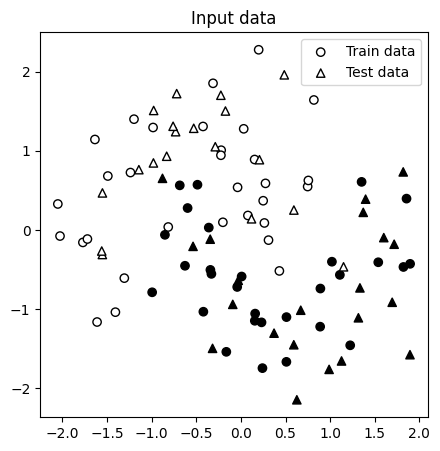

In [ ]:
figure = plt.figure(figsize=(5, 5))
cm = plt.cm.binary
#cm_bright = ListedColormap(['#FF0000', '#0000FF'])
ax = plt.subplot(1,1, 1)

ax.set_title("Input data")
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='binary',
           edgecolors='k', label='Train data')
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='binary',
           edgecolors='k', marker='^', label='Test data')
ax.legend()
plt.show()

**To Do** Apply your methods for Decision Trees and Bagging. First reformatting the data such that the labels are concatenated to the last column of the data matrices

In [ ]:
dataset=np.concatenate((X_train,y_train.reshape((y_train.shape[0],1))),axis=1)
test_dataset=np.concatenate((X_test,y_test.reshape((y_test.shape[0],1))),axis=1)

Now run training and prediction from the Decision Tree Model that we imported earlier

In [ ]:
tree = DT.build_tree(dataset,max_depth,min_size)
prediction_DT1=DT.predict(tree, test_dataset)
score_DT1=DT.score(y_test,prediction_DT1)
print('Our Decision Tree Score', score_DT1)

Our Decision Tree Score 0.875


Ploting the true and predicted values for the test set, side by side (with colour indicating class)

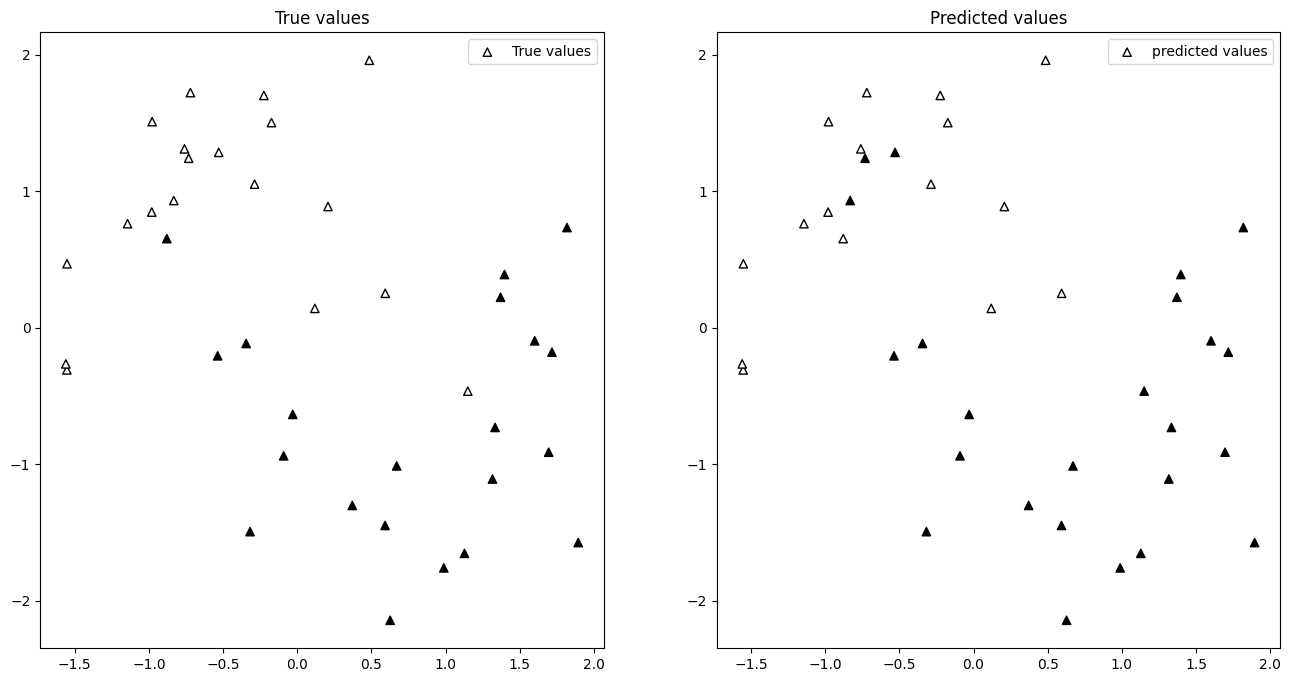

In [ ]:
fig = plt.figure(figsize=(16,8))

cm = plt.cm.RdBu
ax = fig.add_subplot(121)

ax.set_title("True values")
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='binary',
           edgecolors='k', marker='^', label='True values')
ax.legend()


ax = fig.add_subplot(122)
cm = plt.cm.RdBu
#ax = plt.subplot(1,1, 1)

ax.set_title("Predicted values")
ax.scatter(X_test[:, 0], X_test[:, 1], c=prediction_DT1, cmap='binary',
           edgecolors='k', marker='^', label='predicted values')
ax.legend()
plt.show()

Now run training and prediction for you new Bagging Classifier (for different numbers of trees):

In [ ]:
for n_trees in [1, 10, 50]:

    tree_ensemble=create_bagged_ensemble(dataset,max_depth, min_size, n_trees)
    prediction_BG1=bagging_predict(tree_ensemble, test_dataset)
    score_BG1=DT.score(y_test,prediction_BG1)
    print('Our Bagging Score', score_BG1)


Our Bagging Score 0.9
Our Bagging Score 0.925
Our Bagging Score 0.95


Again plotting for the final bagged result

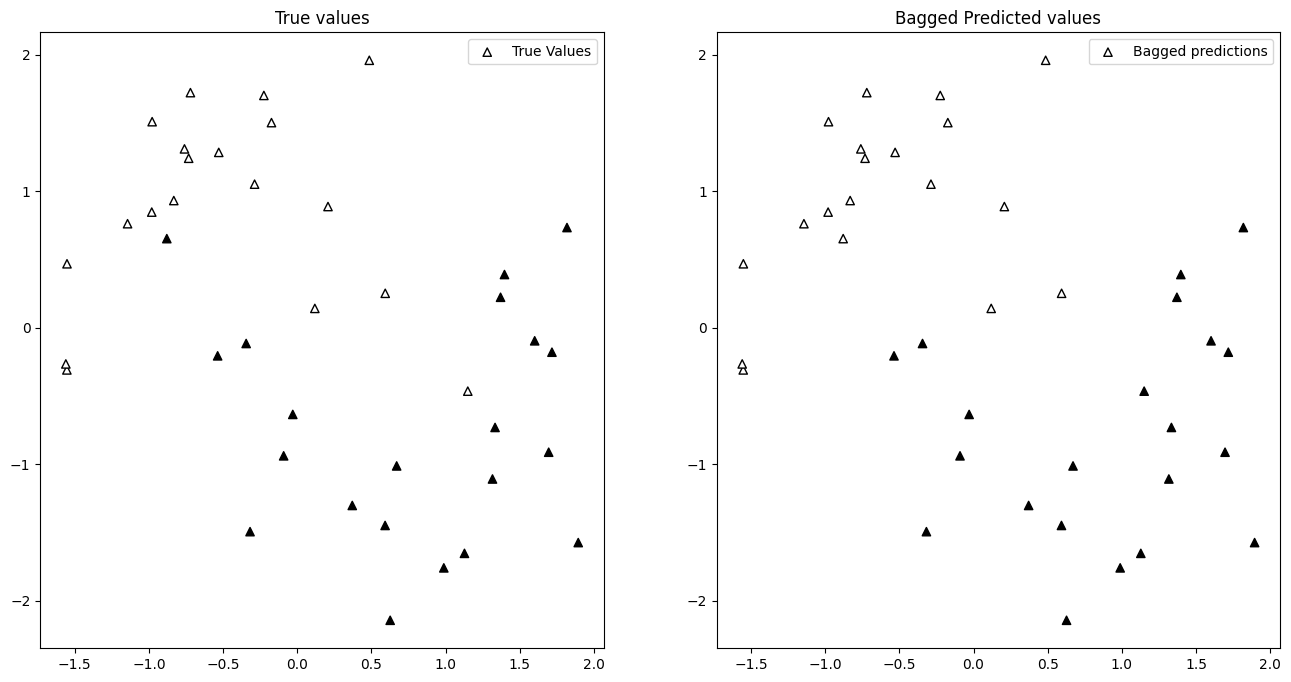

In [ ]:
fig = plt.figure(figsize=(16,8))

ax = fig.add_subplot(121)

ax.set_title("True values")
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='binary',
           edgecolors='k', marker='^', label='True Values')
ax.legend()


ax = fig.add_subplot(122)
cm = plt.cm.RdBu
#ax = plt.subplot(1,1, 1)

ax.set_title("Bagged Predicted values")
ax.scatter(X_test[:, 0], X_test[:, 1], c=prediction_BG1, cmap='binary',
           edgecolors='k', marker='^', label='Bagged predictions')
ax.legend()
plt.show()

Clearly, the bagging classifier improves the prediction result

### Exercise 4 - Comparing against Scikit learn

Scikit learns functions for Decision Tree and Bagging classifiers can be found http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html and  http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html.

Importing these and complete the code below to compare against the results from exercise 3.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

# 4.1 instantiate a scikit learn decision tree classifier
tree_model = None
# 4.2. fit the model
None
# 4.3 return the accuracy on the test set (i.e. score)
score_DT2 = None
# 4.4 return prediction on the test set
prediction_DT2 = None

print('Sklearn Decision Tree Score', score_DT2)
# Bagging 4.5 instantiate a scikit learn bagging classifier
bagging_model = None
# 4.6. fit the model
None
# 4.7 return the accuracy on the test set (i.e. score)
score_BG2 = None
print('Scikit-Learn Bagging score {} using {} Trees'.format(score_BG1,n_trees))

Sklearn Decision Tree Score 0.95
Scikit-Learn Bagging score 0.95 using 50 Trees


It is not surprising the the Scikit Learn decision tree module outperforms ours as it refines its trees through pruning to avoid overfitting

### 2.1.6 Estimating Out-Of-Bag estimates

To evaluate the test error of a bagging estimate we could use cross-validation. However, with each training set we automatically get a left out set. For large enough sample sizes ~37 % of training points are left out. We can use these as a validation set, in order to estimate what is known as the ***Out-of-Bag (OOB) Error***. This can be achieved using the following steps:

- For each sample $x_i$,

  - Find the prediction $\hat{y}_i^b$ for all bootstrap samples b which do not contain $x_i$
  - Average/combine these predictions to obtain $\hat{y}_i^{oob}$ (aggregated score for each training example)
  - Combine to return accuracy/prediction score over all out-of-bag samples
  - (for classification) estimate error as $1- oob_{score}$
  
The scikit-learn Bagging function has inbuilt functionality to calculate the OOB error. This can be utilised by calling the ```BaggingClassifier ``` with the argument ```oob_score```

Plotting the OOB error for different numbers of trees can be observed through the following Scikit-Learn toy dataset problem (adapted from http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html)


[ 50  57  64  71  78  85  92 100 107 114 121 128 135 142 150 157 164 171
 178 185 192 200 207 214 221 228 235 242 250 257 264 271 278 285 292 300
 307 314 321 328 335 342 350 357 364 371 378 385 392 400]


Text(0, 0.5, 'OOB error')

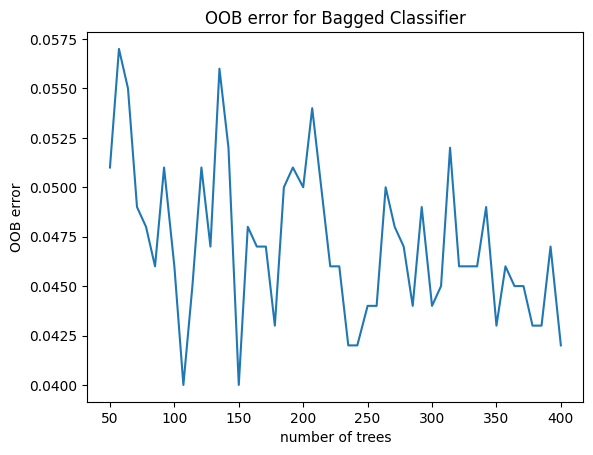

In [ ]:
from sklearn.datasets import make_classification
from sklearn.ensemble import BaggingClassifier

RANDOM_STATE = 42

# Generate a binary classification dataset.
X, y = make_classification(n_samples=1000, n_features=25,
                           n_clusters_per_class=1, n_informative=15,
                           random_state=RANDOM_STATE)


estimator_numbers=np.linspace(50,400,50).astype(int)
print(estimator_numbers)
error_rate=[]
for n_trees in estimator_numbers:
    clf=BaggingClassifier(DecisionTreeClassifier(),n_estimators=n_trees, oob_score=True)
    clf.fit(X, y)
    oob_error = 1 - clf.oob_score_
    error_rate.append(oob_error)

plt.plot(estimator_numbers,error_rate)
plt.title('OOB error for Bagged Classifier')
plt.xlabel('number of trees')
plt.ylabel('OOB error')

### 2.1.7  When not to use Bagging

Bagging is useful for datasets that are noisy and have high variance. In other words if the predictions generated across bagged trees (or any other weak learner) vary significantly from one another then Bagging can significantly help to reduce the variance.

If, on the other hand, the varying the training dataset has little impact on the final predictions then Bagging will not be beneficial. On the contrary, it can be found to degrade the performance of already stable classifiers

## 2.2. Random Forests

Random Forests, first proposed by Adit and Geman {AG1997], and later refined by Breiman [Br2001], are an extension of bagging, which increase randomisation further by sampling from the parameter space ($T$) at each tree node. Thus, when optimising a split of the incomining data, a node must select, not from all features in the data set, but from a subset made available to each root node. A guiding rule of thumb is that each node might see only $d=\sqrt(m)$ or $d=\log_2 m$ of the total number of features $m$.

In this way the assembled trees are further decorrelated from one another than they would be if standard decision trees were constructed and bagged. More specifically, training subsets will take more and more different paths through the decision trees, resulting in greater differences in the distribution of data across leaf nodes.  This has the effect of further decreasing the variance of the ensemble; increasing robustness to noisy training examples and/or features, whose influence gets spread out and diluted across the ensemble.

Training and testing random forests therefore behaves very similarly to that of bagged ensembles of decision trees, with the exception that when optimising for the best split of the data at each node (e.g. see ```get_best_split``` from DecisionTree.py) the data must first be modified to ensure that only a subset of the full feature-space is passed to  the splitting function (e.g. ```test_split```). A summary of the training process is shown below:


<img src="https://raw.githubusercontent.com/MaralAminpour/ML-BME-Course-UofA-Fall-2023/main/Week-7-Ensemble-learning/imgs/randomforest_train.png" style="max-width:100%; width: 80%; max-width: none">


Testing then proceeds exactly as before:


<img src="https://raw.githubusercontent.com/MaralAminpour/ML-BME-Course-UofA-Fall-2023/main/Week-7-Ensemble-learning/imgs/randomforest_test.png" style="max-width:100%; width: 80%; max-width: none">


### 2.2.1 Applying Random Forests using Scikit-Learn

The documentation for Scikit-Learn's Random Forest methods may be found http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html and http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

Important arguments include the option of tuning the ```max_depth``` and ```min_samples_leaf``` (min samples per leaf) for each tree. The number of features available for each node may be tuned through the ```max_features``` argument, the total number of trees in the ensemble is controlled using ```n_estimators``` and the argument for estimating the OOB error is ```oob_score ``` as before. As with all Scikit-Learn modules, to fix the random seed (and thus ensure you return the same results every time) set the ```random_seed```.

An example of how to call the Scikit Learn RF classifier is shown below, applied to the ```make_moons``` data set, (imported and pre-processed above)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf=RandomForestClassifier(max_depth=max_depth, n_estimators=50, random_state=0)
clf.fit(X_train,y_train)
score_RF = clf.score(X_test, y_test)

print('Scikit-Learn Random Forest score on make moons data set', score_RF)
print('Scikit-Learn Decision Tree score on make moons data set', score_DT2)

Scikit-Learn Random Forest score on make moons data set 0.95
Scikit-Learn Decision Tree score on make moons data set 0.95


### Exercise 5: Training Random Forests to Predict Gestational Age from Regional Brain Volumes

Apply Scikit-Learn's Random Forest Regressor to the task of predicting gestational age (GA) from regional brain volumes. Complete the code below to:

   1. implement the training and testing of the ```DecisionTreeRegressor()```
   2. implement the training and testing of the  ```RandomForestRegressor()```
   3. (optional) Return and plot feature importances (see the [scikit-learn tutorial](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html) for guidance)
   
Data pre-processing has been performed for you

In [ ]:
# This code will download the required data files from GitHub
import requests
def download_data(source, dest):
    base_url = 'https://raw.githubusercontent.com/'
    owner = 'SirTurtle'
    repo = 'ML-BME-UofA-data'
    branch = 'main'
    url = '{}/{}/{}/{}/{}'.format(base_url, owner, repo, branch, source)
    r = requests.get(url)
    f = open(dest, 'wb')
    f.write(r.content)
    f.close()

# Create the temp directory, if it doesn't already exist
import os
if not os.path.exists('temp'):
   os.makedirs('temp')

download_data('Week-6-Feature-extraction-and-selection/data/GA-structure-volumes-preterm.csv', 'temp/GA-structure-volumes-preterm.csv')

In [ ]:
## from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np


# load data

DATAMAT=pd.read_csv('temp/GA-structure-volumes-preterm.csv',header=None)

# separate out data from labals

DATA = DATAMAT.loc[:,1:] # volumes - we have 86 features and 164 samples
LABELS = DATAMAT[0] # GA - 164

# split data into test and train
X_train_GA, X_test_GA, y_train_GA, y_test_GA = train_test_split(DATA, LABELS, test_size=.4, random_state=42)

# 5.1 get baseline prediction from decision tree (no param optimisation)
# 5.1.1 create instance of DecisionTreeRegressor with default parameters (1 line)
tree_model=None
# 5.1.2 train
None
# 5.1.3 Test
score_DT = None
print('Decision Tree Score', score_DT)

# 5.2 get baseline prediction from Random Forest (no param optimisation)
# 5.2.1 create instance of RandomForestRegressor with default parameters
forest_model=None
# 5.2.2 train
None
# 5.2.3 test
score_RF1 = None
print('Random Forest initial Score', score_RF1)

# 5.3. get feature importances
importances = None
std = None
indices = None

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train_GA.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the 20 most important features in the forest
plt.figure(figsize=(10,8))
plt.title("Feature importances")
plt.bar(range(20), importances[indices][0:20],
        color="r", yerr=std[indices][0:20], align="center")
plt.xticks(range(20), indices[0:20])
plt.xlim([-1, 20])
plt.show()


### 2.2.2 Parameter Tuning

As indicated above, the Scikik-learn module allows for tuning of several key parameters of the model. Of these, perhaps the most important are:

- Number of features
- Max depth of trees
- Number of estimators

We will now use Scikit-Learn's ```GridSearchCV``` function to optimise the parameters of our Random Forest and improve performance on the above problem.

For help on how to implement parameter optimisation using GridSearch, look at the scikit learn [documentation](https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html#sphx-glr-auto-examples-model-selection-plot-grid-search-digits-py)

### Exercise 6 (optional):  Perform Parameter Optimisation for Random Forests using ```GridSearchCV```

Implement parameter optimisation using ```GridSearchCV``` by:
   1. Creating a ```dict``` called ```param_dist``` which specifies parameters for ```max_depth```, ```max_features``` and ```n_estimators ```
   2. create an instance (```grid```) of  ```GridSearchCV``` with ```RandomForestRegressor()``` as the model and ```param_dist``` as the search grid (with cross validation: ```cv=5``` and ```iid=False```; then run on the training data
   3. Apply the tuned parameters to the model and get a new test prediction
  

In [ ]:
from sklearn.model_selection import GridSearchCV

# 6.1 specify parameters and distributions to sample from in the form of a dict (3 lines)
param_dist = None

model=RandomForestRegressor(random_state=42)
# 6.2 create an instance of GridSearchCV (1 line)
grid = None
# run gridsearch on the training data (1 line)
grid.fit(X_train_GA, y_train_GA)

# summarize the results of the grid search
print('Best classification score achieved using grid search:', grid.best_score_)
print('The parameters resulting in the best score are depth: {},max_f {} and n_estimators {} '\
      .format(grid.best_estimator_.max_depth,grid.best_estimator_.max_features,\
              grid.best_estimator_.n_estimators))

#6.3.1 create RF model using optimised parameters (1 lines)
model=None

#6.3.2 fit model to training data
None
#6.3.3 Test
score_RF2 = None
print('Random Forest refined test Score', score_RF2)

### Exercise 7 (optional) Building a Random Forest Classifier from scratch

In short this will require simple copying and pasting of the existing code (for Decision Trees and Bagging) followed by minor modification of the ```get_best_split``` function to ensure that only a subset of the available features are evaluated by ```test_split```.

Give this a go, and then test on the ```make_moons``` data set, as demoed previously for the DecisionTree and Bagging modules, and as shown below for the Scikit-Learn methods.

**To do**

1. copy and paste the code for Bagging.py into a new script for a random forest module.
2. edit ```get_best_split``` as described above
3. test on the scikit learn ```make_moons```

In [ ]:
# To do - test your random forest on make moons here

## 2.3 Boosting

Boosting is a method for sequential ensemble learning that works by building simple prediction models, one after the other, reweighting training data each time to give added importance to training examples that were misclassified in the previous round. In this way, each new predictor is encouraged to work harder on border cases, incrementally reducing the bias of the model.

The basic principle of boosting is shown below for the given toy example:

<img src="https://raw.githubusercontent.com/MaralAminpour/ML-BME-Course-UofA-Fall-2023/main/Week-7-Ensemble-learning/imgs/adaboosttoyexample.png" style="max-width:100%; width: 40%; max-width: none">

Here, a simple classification problem is shown for two classes (positive=red cross and negative=blue minuses). A simple classifier is fit based on thresholding on a single feature (red rectangle). This classifies everything to the left hand side as positive. We see that 3 red crosses are therefore missclassified by this rule. These examples are then reweighted to give them greater importance in the next training round:

<br>

<img src="https://raw.githubusercontent.com/MaralAminpour/ML-BME-Course-UofA-Fall-2023/main/Week-7-Ensemble-learning/imgs/adaboosttoyexample_round2.png" style="max-width:100%; width: 60%; max-width: none">

In this round, examples that were previously misclassified are upweighted (reflected by increase in size) and those that were correctly classified are downweighted (made smaller). A second model is fit, shown by the new red box. Now three negative examples are misclassified. These are upweighted in a third round:

<br>

<img src="https://raw.githubusercontent.com/MaralAminpour/ML-BME-Course-UofA-Fall-2023/main/Week-7-Ensemble-learning/imgs/adaboosttoyexample_round3.png" style="max-width:100%; width: 60%; max-width: none">

This creates a third proposed weak-learner (or split of the data). The three weak rules are then subsequently combined together to generate one final prediction model:

<img src="https://raw.githubusercontent.com/MaralAminpour/ML-BME-Course-UofA-Fall-2023/main/Week-7-Ensemble-learning/imgs/adaboosttoyexample_final.png" style="max-width:100%; width: 50%; max-width: none">


## 2.3.1 Adaboost

There are several variants of boosting; however in this lecture we will only consider the first: Adaboost [Fr1997], addressing the following implementational choices:

- What to use as weak learners?
- How to weight the examples?
- How many weak learners should be learnt?
- How to combine weak learners at the end?

In the original form of Adaboost the choice of weak learner is effectively a simple threshold on a single feature in the data, otherwise known as a decision stump (or decision tree with only once split):

<img src="https://raw.githubusercontent.com/MaralAminpour/ML-BME-Course-UofA-Fall-2023/main/Week-7-Ensemble-learning/imgs/decisionstump.png" style="max-width:100%; width: 20%; max-width: none">

However, it is important to note that modern implementations (including that of Scikit-Learn) open the possibility for parameterising Adaboost to use deeper trees (this option can be tuned during parameter optimisation).

Examples are initially all given the same weight ($w_i=1/n$, for $n$ = the number of examples). Then these are down-weighted if correctly classified (or regressed precisely) and left unchanged if incorrectly predicted

Each weak learner’s job is to find the best weak hypothesis $f_t (\mathbf{X}, \theta) : \mathbb{R}^d \times \Gamma \rightarrow {0,1}$  (for classification) suited to fitting to the current weighted distribution of examples $\mathbf{p}^t$. Subsquently, the weighted error of the prediction is calculated ($\epsilon_t$) and weights are redistributed according the performance of the given weak learner (through $\beta$).

### 2.3.2 Adaboost Classification

For classification, the boosting algorithm is given by the following algorithm:

<img src="https://raw.githubusercontent.com/MaralAminpour/ML-BME-Course-UofA-Fall-2023/main/Week-7-Ensemble-learning/imgs/adaboost_algorithm.png" style="max-width:100%; width: 70%; max-width: none">

Specifically, correctly classified examples are downweighted by assigning weights $w_i^{t+1}$ equal to $w_i^{t}\beta_t$ (whereas misclassified examples retain weight $w_i^{t}$). This applies as $|f_t(\mathbf{x_i})-y_i|=0$ for correctly classified examples and $|f_t(\mathbf{x_i})-y_i|=1$ for incorrectly classified examples.  The final hypothesis is then estimated from a weighted contribution of all weak learners as follows:

$$ F(\mathbf{x_i})= \left\{
    \begin{array}{l}
      1  \textrm{    if   } \sum_t^T \ln(1/\beta_t)f_t(\mathbf{x_i}) \geq \sum_t^T \ln(1/\beta_t) \\
      0  \textrm{   otherwise }
    \end{array}
  \right.$$

Thus, Adaboost reduces the overall model error by incrementally improving classification of border cases, so as to reduce bias, over $T$ rounds of classification. Boosting can also be seen to be robust to overfitting (thus reducing model variance). This is typically explained through the observation that even when training error has been reduced to zero, further refinements continue to be made on the estimation of marginal cases. In this way the confidence of the predictions made on the training data continues to increase, resulting in a better generalisation performance. See [Sch2013] for a more complete explanation.

### 2.3.3 Adaboost Regression

The original algorithm [Fr1997] was designed for classification, but [Dr1997] proposes a modification suited to regression.

In this, the algorithm proceeds as above but regression specific loss functions are used to estimate prediction error (these can be linear, squared or exponential function [Dr1997]), and thus subsequently the next round of weights:

<img src="https://raw.githubusercontent.com/MaralAminpour/ML-BME-Course-UofA-Fall-2023/main/Week-7-Ensemble-learning/imgs/adaboost_regression1.png" style="max-width:100%; width: 60%; max-width: none">

The final prediction is then estimated from the weighted median of predictions from all $T$ weak learners (where weights are defined as $\ln(1/\beta_t)$)


### 2.3.4 Applying Adaboost using Scikit-Learn

The documentation for Scikit-Learn's Adaboost methods may be found http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html and http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html#sklearn.ensemble.AdaBoostRegressor

Important arguments include the choice of baselearner (by default this is a decision tree), the number of estimators fit, and (for regression only) the choice of loss function (linear, squared, exponential). Again, an argument ```random_state``` is available to fix the seed of the random number generator (to ensure consistency of results over multiple runs).

An example of how to call the Scikit Learn Adaboost classifier is shown below, appled to the make_moons data set, (imported and pre-processed above)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

# train Adaboost on make_moons training set defined above

clf=AdaBoostClassifier(random_state=0)
clf.fit(X_train,y_train)
score_AB = clf.score(X_test, y_test)
print('Scikit-Learn AB score', score_AB)

#recalling previous results
print('Scikit-Learn Random Forest score on make moons data set', score_RF)
print('Scikit-Learn Decision Tree score on make moons data set', score_DT2)

### Example: Training Adaboost to Predict Gestational Age from Regional Brain Volumes¶

Apply Scikit-Learn's Adaboost regressor to the task of predicting gestational age (GA) from regional brain volumes.

Using the test training data split from above (```X_train_GA, X_test_GA, y_train_GA, y_test_GA```) complete the code below to:
   1.  Trial Adaboost Regression using default parameters
   2.  Try optimising parameters (such as min_samples_leaf and n_estimators) using GridSearchCV. Note, the entry for min_samples_leaf in the parameter dict has been completed for you to demonstrate how to tune the parameters of a base learner (in this case a decision tree)
   3.  Apply the optimised parameters to train and test a new model. (Note given the parameters in param_dist I was not able to improve the test result - see if you can do better)

In [ ]:
# This code will download the required data files from GitHub
import requests
import pandas as pd

def download_data(source, dest):
    base_url = 'https://raw.githubusercontent.com/'
    owner = 'SirTurtle'
    repo = 'ML-BME-UofA-data'
    branch = 'main'
    url = '{}/{}/{}/{}/{}'.format(base_url, owner, repo, branch, source)
    r = requests.get(url)
    f = open(dest, 'wb')
    f.write(r.content)
    f.close()

# Create the temp directory, if it doesn't already exist
import os
if not os.path.exists('temp'):
   os.makedirs('temp')

download_data('Week-6-Feature-extraction-and-selection/data/GA-structure-volumes-preterm.csv', 'temp/GA-structure-volumes-preterm.csv')


# Train-test data split from Exercise 5:
# load data

DATAMAT=pd.read_csv('temp/GA-structure-volumes-preterm.csv',header=None)

# separate out data from labals

DATA = DATAMAT.loc[:,1:] # volumes - we have 86 features and 164 samples
LABELS = DATAMAT[0] # GA - 164

# split data into test and train
X_train_GA, X_test_GA, y_train_GA, y_test_GA = train_test_split(DATA, LABELS, test_size=.4, random_state=42)

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

# 8 get baseline prediction from Adaboost (no param optimisation)
# 8.1 create instance of Adaboost with default parameters (1 line)
clf=AdaBoostRegressor(random_state=42)
# 8.1.1 Train on data X_train_GA, y_train_GA (1 line)
clf.fit(X_train_GA, y_train_GA)
# 8.1.2 Test
score_AB1 = clf.score(X_test_GA, y_test_GA)
print('Adaboost initial Score', score_AB1)


# optimise parameters using GridSearchCV
# specify parameters and distributions to sample from in the
#form of a dict (2 lines)
param_dist = {"estimator__min_samples_leaf": [1,2,3, 5, 10],
              "n_estimators": [5,10,25,10, 50,100,150,200,500]
              }

model=AdaBoostRegressor(DecisionTreeRegressor())
# 8.2 create an instance of GridSearchCV (1 line)
grid = GridSearchCV(estimator=model, param_grid=param_dist,cv=5,scoring='neg_mean_squared_error')
# 8.3 run gridsearch on the training data (1 line)
grid.fit(DATA, LABELS)

print('Best regression score achieved using grid search:', grid.best_score_)
print('The parameters resulting in the best score are min samples per leaf: {}, \
      and n_estimators {} '.format(
    grid.best_estimator_.estimator_.min_samples_leaf,grid.best_estimator_.n_estimators))

# 8.3.1 create RF model using optimised parameters (1 lines)
model=AdaBoostRegressor(estimator=DecisionTreeRegressor(
    min_samples_leaf=grid.best_estimator_.estimator_.min_samples_leaf),
                            n_estimators=grid.best_estimator_.n_estimators,
                            random_state=42)
# 8.3.1 fit model to training data
model.fit(X_train_GA, y_train_GA)
# 8.3.1 Test
score_AB2 = model.score(X_test_GA, y_test_GA)
print('Adaboost refined test Score', score_AB2)

Adaboost initial Score 0.9055990872670802
Best regression score achieved using grid search: -1.0992725948863638
The parameters resulting in the best score are min samples per leaf: 1,       and n_estimators 200 
Adaboost refined test Score 0.909819111198983


# Citations

[AG1997] Amit, Yali, and Donald Geman. "Shape quantization and recognition with randomized trees." Neural computation 9.7 (1997): 1545-1588.

[Br2001] Breiman, Leo. "Random forests." Machine learning 45.1 (2001): 5-32.

[Fr1997] Y. Freund, and R. Schapire, “A Decision-Theoretic Generalization of On-Line Learning and an Application to Boosting”, 1997.

[Sch2013] Schapire, Robert E. "Explaining adaboost." Empirical inference. Springer, Berlin, Heidelberg, 2013. 37-52.

[Dr1997] Drucker. “Improving Regressors using Boosting Techniques”, 1997.
